In [1]:
%%capture
!pip install -r ../requirements.txt

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

SCRIPT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../scripts"))
if SCRIPT_DIR not in sys.path:
    sys.path.append(SCRIPT_DIR)
from config import YEARS, RAW_PATH, PROCESSED_PATH, RESULTS_PATH, WDI_INDICATORS, VDEM_VARIABLES, VDEM_DOWNLOAD_URL, TARGET_VARIABLE, BARRO_LEE_FILENAME, VARIANCE_ANALYSIS, CLUSTERING_VARIABLES
from load_vdem import load_vdem_subset
from load_wdi import load_and_average_wdi_indicator
from load_barro_lee import load_barro_lee_subset

# 1 Datensatz erstellen

Im ersten Schritt werden die Daten aus den verschiedenen Quellen geladen und auf die für die Analyse relevanten Variablen und Jahre gefiltert. Dabei werden V-Dem-, Weltbank- und Barro-Lee-Daten jeweils separat verarbeitet.

## 1.1 V-Dem: Daten laden & filtern

In [3]:
vdem_df, vdem_variances_df = load_vdem_subset(
    years=YEARS,
    variables= VDEM_VARIABLES,
    download_url= VDEM_DOWNLOAD_URL,
    raw_path= RAW_PATH,
    processed_path= PROCESSED_PATH,
    save_as="vdem_subset_filtered.csv",
    compute_variance = VARIANCE_ANALYSIS
)

Lade V-Dem ZIP-Datei herunter ...
Entpacke ZIP-Datei ...
Lade und filtere CSV-Datei ...
Berechne Durchschnitt pro Land ...
V-Dem-Durchschnitt gespeichert unter: ../data/processed/vdem_subset_filtered.csv


## 1.2 WDI: Indikatoren laden

In [4]:
wdi_dfs = []
metadata_frames = []
wdi_variances_dfs = []
for wdi_code in WDI_INDICATORS:
    # Indikator laden + zugehörige Metadaten holen
    df, metadata, variance = load_and_average_wdi_indicator(
        wdi_code,
        years=YEARS,
        raw_path=RAW_PATH,
        processed_path=PROCESSED_PATH,
        compute_variance = VARIANCE_ANALYSIS
    )

    # Spalten umbenennen
    wdi_dfs.append(df)

    metadata_frames.append(metadata)
    wdi_variances_dfs.append(variance)

# Alle Metadaten zusammenführen
metadata_df = pd.concat(metadata_frames, ignore_index=True)
metadata_unique = metadata_df.drop_duplicates(subset=["Country Code"])

# Speichern
meta_path = os.path.join(PROCESSED_PATH, "Master_Metadata.csv")
metadata_unique.to_csv(meta_path, index=False)
print(f"Master-Metadaten gespeichert unter: {meta_path}")

Metadata gespeichert: ../data/processed/Metadata_SE.XPD.TOTL.GD.ZS.csv
Metadata gespeichert: ../data/processed/Metadata_IT.NET.USER.ZS.csv
Metadata gespeichert: ../data/processed/Metadata_SE.ADT.LITR.ZS.csv
Metadata gespeichert: ../data/processed/Metadata_NY.GDP.PCAP.CD.csv
Metadata gespeichert: ../data/processed/Metadata_NE.CON.PRVT.ZS.csv
Metadata gespeichert: ../data/processed/Metadata_FP.CPI.TOTL.ZG.csv
Metadata gespeichert: ../data/processed/Metadata_SP.URB.TOTL.IN.ZS.csv
Metadata gespeichert: ../data/processed/Metadata_SH.XPD.CHEX.PC.CD.csv
Metadata gespeichert: ../data/processed/Metadata_SP.POP.TOTL.csv
Metadata gespeichert: ../data/processed/Metadata_SI.POV.GINI.csv
Metadata gespeichert: ../data/processed/Metadata_SL.UEM.TOTL.ZS.csv
Master-Metadaten gespeichert unter: ../data/processed/Master_Metadata.csv


## 1.3. Barro-Lee: Durchschnittliche Schuljahre laden

In [5]:
barro_df = load_barro_lee_subset(target_year = 2010)

 Barro-Lee Daten für 2010 gespeichert unter: ../data/processed/barro_lee_2010.csv


## 1.4. Varianzen berechnen
Hintergrund: Beobachtungszeitraum & Varianzbewertung
Ziel dieses Blocks ist es, einen geeigneten Beobachtungszeitraum (z. B. 5 oder 10 Jahre) festzulegen, der zwischen Datenverfügbarkeit und Aussagekraft eines Mittelwerts abwägt. Ein längerer Zeitraum liefert tendenziell vollständigere Daten, erhöht aber auch die Varianz innerhalb der Werte, wodurch der Mittelwert weniger repräsentativ werden kann.

Deshalb wird hier die durchschnittliche Varianz je Variable berechnet.
Die Konfiguration (YEARS) wurde dabei manuell angepasst, und das Notebook zweimal ausgeführt– einmal für 5 Jahre und einmal für 10 Jahre.
Die berechneten Varianzen dienten ausschließlich zur Einschätzung und Auswahl des Zeitraums, nicht für die weitere Analyse.

In [6]:
if VARIANCE_ANALYSIS:
    # Alle Varianz-DataFrames (WDI + V-Dem) zu einer Übersicht zusammenführen
    df_var_summary = pd.concat(wdi_variances_dfs + [vdem_variances_df], ignore_index=True)

    # Nach mittlerer Varianz über Länder sortieren
    df_var_summary = df_var_summary.sort_values("Median Varianz über Länder", ascending=True)

    # Ergebnis als CSV-Datei speichern
    filename = f"df_var_summary_{min(YEARS)}_{max(YEARS)}.csv"
    output_path = os.path.join(RESULTS_PATH, filename)
    df_var_summary.to_csv(output_path, index=False)
    print(f"Varianz-Zusammenfassung gespeichert unter: {output_path}")

    # Berechnung und Ausgabe der Gesamt-Medianvarianz zur Einordnung
    gesamt_median = df_var_summary["Median Varianz über Länder"].median()
    print(f"Gesamter Median der Länder-Varianzen über alle Variablen: {gesamt_median:.4f}")


## 1.5 Datensätze mergen

In [7]:
# Country-Namen aus V-DEM-Frame extrahieren
country_names = vdem_df[["Country Code", "Country Name"]].drop_duplicates()

# WDI-Frames ohne "Country Name" vorbereiten, um Mergen zu erleichtern
wdi_clean = [df.drop(columns=["Country Name"], errors="ignore") for df in wdi_dfs]

# Weltbankdaten zu Hauptdatensatz mergen
df_master = reduce(lambda left, right: pd.merge(left, right, on="Country Code", how="outer"), wdi_clean)

# Barro-Lee vorbereiten 
barro_df_clean = barro_df.drop(columns=["Country Name"], errors="ignore")

# Barro-Lee in Hauptdatensatz mergen
df_master = pd.merge(df_master, barro_df_clean, on="Country Code", how="outer")

# Metadata vorbereiten 
metadata_df_clean = metadata_df.drop(columns=["TableName","SpecialNotes"], errors="ignore")

# Metadata in Hauptdatensatz mergen
df_master = pd.merge(df_master, metadata_df_clean, on="Country Code", how="outer")

# V-Dem vorbereiten 
vdem_df_clean = vdem_df.drop(columns=["Country Name"], errors="ignore")

# V-Dem in Hauptdatensatz mergen(hier werden nur Länder mit existierendem Wert für die Zielvariable verwendet)
vdem_valid = vdem_df_clean[vdem_df_clean["v2x_partipdem"].notna()]
df_master = pd.merge(df_master, vdem_valid, on="Country Code", how="inner")

# Country Name wieder anhängen
df_master = pd.merge(country_names, df_master, on="Country Code", how="right")

# Entferne leere "Unnamed"-Spalten
df_master = df_master.loc[:, ~df_master.columns.str.contains("^Unnamed")]
df_master = df_master.drop_duplicates(subset=["Country Code"])

# Ergebnis anzeigen
print(f"Finale Länderanzahl: {df_master.shape[0]}")
print(f"Spaltenanzahl: {df_master.shape[1]}")

# Speichern
output_path = os.path.join(RESULTS_PATH, "dataset_merged.csv")
df_master.to_csv(output_path, index=False)
print(f"Master-Datensatz gespeichert unter: {output_path}")

Finale Länderanzahl: 176
Spaltenanzahl: 32
Master-Datensatz gespeichert unter: ../results/dataset_merged.csv


# 2 Preprocessing der Daten

## 2.1 Analyse fehlender Werte und Datenabdeckung

In [8]:
# Anteil fehlender Werte je Variable
missing_per_variable = df_master.isna().mean().sort_values(ascending=False)
print(missing_per_variable.head(10))

# Anteil fehlener Werte je Land
df_tmp = df_master.set_index("Country Code")
missing_per_country = 1 - (df_tmp.notna().sum(axis=1) / df_tmp.shape[1])
missing_per_country = missing_per_country.sort_values(ascending=False)
print(missing_per_country.head(10))

SE.ADT.LITR.ZS         0.431818
SE.XPD.TOTL.GD.ZS      0.284091
SI.POV.GINI            0.278409
Avg Years Schooling    0.198864
NE.CON.PRVT.ZS         0.102273
FP.CPI.TOTL.ZG         0.051136
SL.UEM.TOTL.ZS         0.022727
SH.XPD.CHEX.PC.CD      0.022727
NY.GDP.PCAP.CD         0.022727
IT.NET.USER.ZS         0.017045
dtype: float64
Country Code
TWN    0.419355
PRK    0.258065
ERI    0.193548
XKX    0.193548
TKM    0.193548
SOM    0.161290
SUR    0.161290
VEN    0.161290
TTO    0.129032
SLB    0.129032
dtype: float64


## 2.2 Random Forest Imputation fehlender Daten

In [9]:
# Taiwan wurde aufgrund vollständig fehlender sozioökonomischer Kontextdaten (Weltbankindikatoren) aus der Analyse ausgeschlossen.
df_master = pd.read_csv("../results/dataset_merged.csv")
df_master = df_master[df_master["Country Code"] != "TWN"] 

# Income Groupe von Venezuela Manuell zu Upper-middle-income setzen, da fehlend in Datensatz
df_master.loc[df_master["Country Code"] == "VEN", "IncomeGroup"] = "Upper middle income"

# Spalten mit fehlenden numerischen Werten finden
numerical_cols = df_master.select_dtypes(include=["float64", "int64"]).columns
cols_with_na = [col for col in numerical_cols if df_master[col].isna().sum() > 0]

# Imputer initialisieren 
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

# Nur numerische Spalten mit NaNs imputieren
df_imputed_values = imputer.fit_transform(df_master[cols_with_na])

# In DataFrame umwandeln
df_imputed = pd.DataFrame(df_imputed_values, columns=cols_with_na, index=df_master.index)

# Original DataFrame aktualisieren
df_master.loc[:, cols_with_na] = df_imputed

# 5. Zwischenergebnis speichern
output_path = os.path.join(RESULTS_PATH, "dataset_imputed.csv")
df_master.to_csv(output_path, index=False)
print(f"Imputation abgeschlossen und gespeichert unter: {output_path}")


Imputation abgeschlossen und gespeichert unter: ../results/dataset_imputed.csv


## 2.3 Erneute Analyse fehlender Werte und Datenabdeckung

In [10]:
# Anteil fehlender Werte je Variable
missing_per_variable = df_master.isna().mean().sort_values(ascending=False)
print(missing_per_variable.head(10))

# Anteil fehlener Werte je Land
df_tmp = df_master.set_index("Country Code")
missing_per_country = 1 - (df_tmp.notna().sum(axis=1) / df_tmp.shape[1])
missing_per_country = missing_per_country.sort_values(ascending=False)
print(missing_per_country.head(10))

Country Code      0.0
Country Name      0.0
v2elrstrct        0.0
v2elpubfin        0.0
v2eldonate        0.0
v2dlengage        0.0
v2dlconslt        0.0
v2clsocgrp        0.0
v2xeg_eqprotec    0.0
v2xeg_eqdr        0.0
dtype: float64
Country Code
AFG    0.0
PAK    0.0
NER    0.0
NGA    0.0
NIC    0.0
NLD    0.0
NOR    0.0
NPL    0.0
NZL    0.0
OMN    0.0
dtype: float64


# 3 Analyse

## 3.1 Korrelationsanalyse 

Bevor ein Modell zur Bestimmung der Einflussfaktoren auf die partizipative Demokratie (Zielvariable: v2x_partipdem) erstellt wird, ist es wichtig zu prüfen, ob einige der potenziellen Prädiktoren stark miteinander korrelieren. Hohe Korrelationen zwischen erklärenden Variablen (Multikollinearität) können Modellverzerrungen verursachen und die Interpretation erschweren.

In diesem Schritt werden daher:
- alle numerischen Variablen außer der Zielvariable extrahiert,
- eine Korrelationsmatrix auf Basis der absoluten Pearson-Korrelation berechnet,
- stark korrelierte Paare (Schwellenwert: > 0.85) identifiziert und tabellarisch ausgegeben,
- eine visuelle Heatmap zur Übersicht aller Korrelationen dargestellt.


Stark korrelierte Variablenpaare (Korrelationskoeffizient > 0.85) :
     Feature 1         Feature 2  Korrelationskoeffizient
      v2x_rule          v2x_corr                 0.926385
NY.GDP.PCAP.CD SH.XPD.CHEX.PC.CD                 0.920372
      v2x_rule         v2x_jucon                 0.914264
    v2dlconslt        v2dlengage                 0.877862
     v2x_jucon      v2xlg_legcon                 0.867183


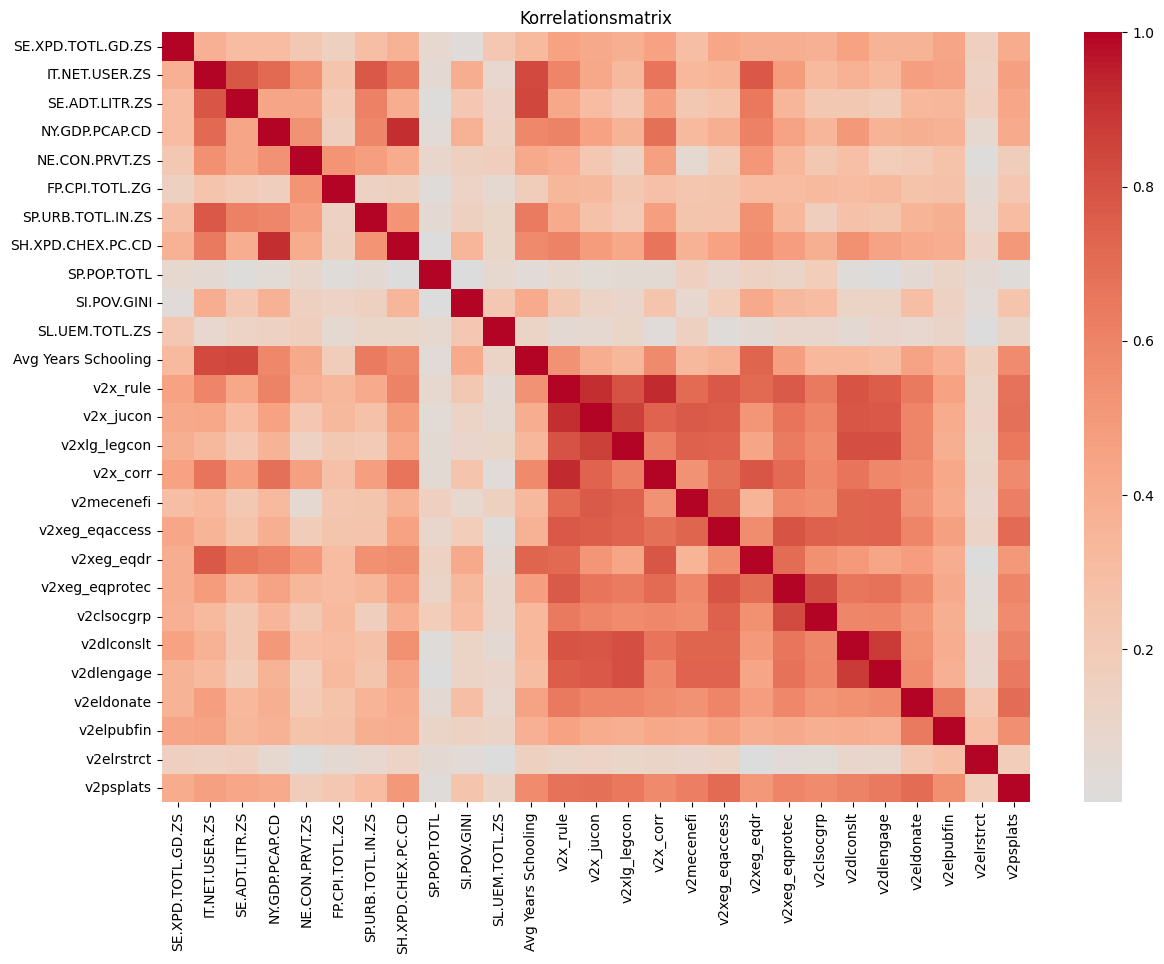

In [11]:
feature_cols = df_master.select_dtypes(include=["float64", "int64"]).columns
feature_cols = [col for col in feature_cols if col != TARGET_VARIABLE]
df_feat = df_master[feature_cols]

# Korrelationsmatrix erstellen
corr_matrix = df_feat.corr().abs()

# Korrelationsanalyse
high_corr_df = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Korrelationskoeffizient"})
    .query("Korrelationskoeffizient > 0.85")
    .sort_values(by="Korrelationskoeffizient", ascending=False)
)

print("Stark korrelierte Variablenpaare (Korrelationskoeffizient > 0.85) :")
print(high_corr_df.to_string(index=False))

# Heatmap anzeigen und speichern
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Korrelationsmatrix")
plt.savefig(os.path.join(RESULTS_PATH, "korrelationsmatrix.png"), dpi=300, bbox_inches="tight")
plt.show()

## 3.2 Globale Feature Importance Analyse 

In diesem Schritt wird ein Random-Forest-Modell verwendet, um die relative Bedeutung (Feature Importance) aller potenziellen Einflussfaktoren auf den Partizipationsindex (v2x_partipdem) zu bestimmen. Die Analyse erfolgt global, also über alle Länder hinweg. Die resultierenden Wichtigkeitswerte geben an, welche Merkmale den größten Beitrag zur Erklärung der Zielvariable leisten.
Basierend auf diesen Werten können irrelevante oder wenig aussagekräftige Variablen identifiziert und aus der weiteren Analyse ausgeschlossen werden.

In [12]:
# Eingabe-Features (X) und Zielvariable (y) definieren
X = df_master[feature_cols].copy()
y = df_master[TARGET_VARIABLE].copy()

# Random Forest Modell initialisieren und trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Feature Importance berechnen und in DataFrame umwandeln
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n Feature Importance (Random Forest für v2x_partipdem):")
print(importances.to_string(index=False))


 Feature Importance (Random Forest für v2x_partipdem):
            Feature  Importance
          v2x_jucon    0.232162
         v2mecenefi    0.166297
           v2x_rule    0.151665
       v2xlg_legcon    0.100968
     v2xeg_eqaccess    0.100404
         v2dlengage    0.095364
     v2xeg_eqprotec    0.023013
  SH.XPD.CHEX.PC.CD    0.022970
          v2psplats    0.019556
         v2dlconslt    0.019420
     IT.NET.USER.ZS    0.011135
  SP.URB.TOTL.IN.ZS    0.007842
     NY.GDP.PCAP.CD    0.005281
         v2eldonate    0.005211
           v2x_corr    0.005140
         v2elpubfin    0.004658
     NE.CON.PRVT.ZS    0.004362
         v2clsocgrp    0.003122
     SL.UEM.TOTL.ZS    0.003055
         v2xeg_eqdr    0.003018
        SP.POP.TOTL    0.002871
  SE.XPD.TOTL.GD.ZS    0.002823
Avg Years Schooling    0.002559
     FP.CPI.TOTL.ZG    0.002559
     SE.ADT.LITR.ZS    0.002247
        SI.POV.GINI    0.002095
         v2elrstrct    0.000203


In [13]:
# Diese vier Variablen werden wegen starker Korrelation mit andern Variablen und auf Basis der Feature Importance entfernt
vars_to_drop = ["v2x_rule", "v2x_corr", "v2dlconslt", "v2xlg_legcon", "SH.XPD.CHEX.PC.CD"]

df_cleaned = df_master.drop(columns=vars_to_drop)
df_cleaned.to_csv(os.path.join(RESULTS_PATH, "dataset_cleaned.csv"), index=False)
print("Datensatz ohne stark korrelierte Variablen gespeichert.")

Datensatz ohne stark korrelierte Variablen gespeichert.


## 3.3. Clustering

### 3.3.1 Skalieren

Um sicherzustellen, dass alle Einflussfaktoren im Clustering möglichst gleich gewichtet werden, werden die ausgewählten numerischen Variablen mittels Standardisierung (StandardScaler) auf Mittelwert = 0 und Standardabweichung = 1 gebracht. Dies verhindert, dass Variablen mit größeren Wertebereichen (z. B. BIP) den Clustering-Prozess dominieren. Die beiden Variablen Inflation und Bevölkerungszahl wurden vom Clustering ausgeschlossen, da sie sich als potenzielle Verzerrungsfaktoren erwiesen – etwa durch extreme Ausreißer (Inflation) oder enorm unterschiedliche Skalenniveaus (Bevölkerung), die selbst nach Standardisierung zu einer unangemessenen Gewichtung im Clustering führen könnten.

In [14]:
# Skalieren
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_cleaned[CLUSTERING_VARIABLES])
df_scaled = pd.DataFrame(scaled_values, columns=[f"{col}" for col in CLUSTERING_VARIABLES])

# Kontextspalten beibehalten 
context_cols = ["Country Code", "Country Name", "Region", "IncomeGroup"]
for col in context_cols:
    if col in df_cleaned.columns:
        df_scaled[col] = df_cleaned[col]
output_path = os.path.join(RESULTS_PATH, "cluster_input_scaled.csv")
df_scaled.to_csv(output_path, index=False)
print(f" Skalierte Variablen gespeichert unter: {output_path}")

 Skalierte Variablen gespeichert unter: ../results/cluster_input_scaled.csv


### 3.3.2 Anzahl der Cluster bestimmen

Um eine geeignete Anzahl an Clustern für die anschließende Gruppierung der Länder zu finden, werden zwei gängige Metriken angewendet: die Elbow-Methode (Inertia) und der Silhouette Score. Beide helfen dabei abzuschätzen, bei welcher Clusteranzahl eine sinnvolle Balance zwischen Homogenität innerhalb der Cluster und Trennschärfe zwischen den Clustern erreicht wird.

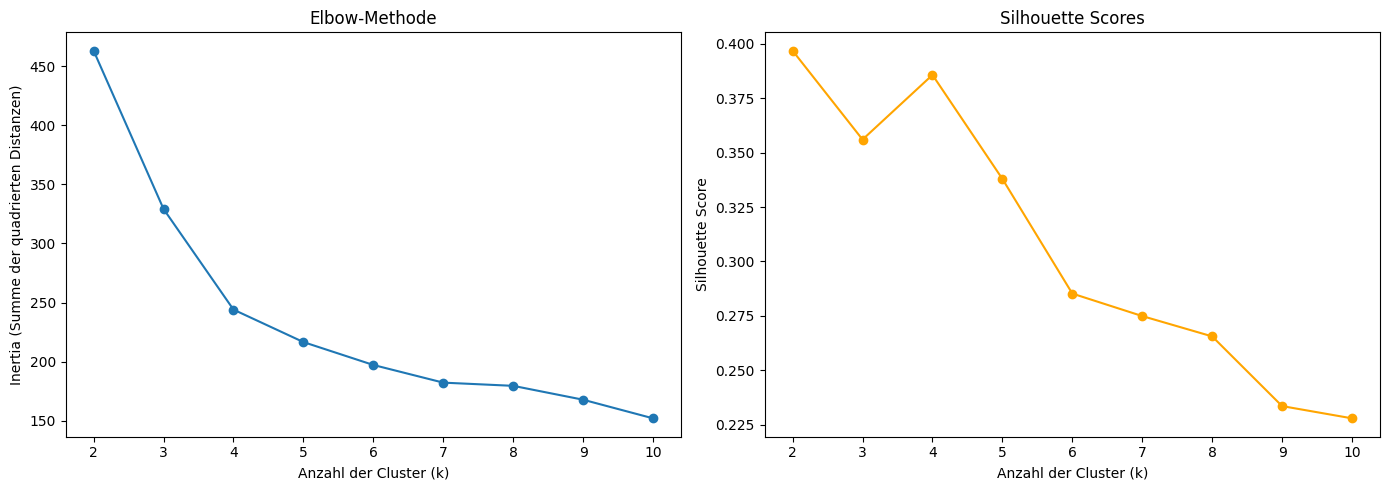

In [15]:
# Feature-Auswahl (alle numerischen Spalten ohne Kontextspalten)
context_cols = ["Country Code", "Country Name", "Region", "IncomeGroup"]
feature_cols = [col for col in df_scaled.columns if col not in context_cols]

X = df_scaled[feature_cols]

# Cluster-Anzahl-Bereich
k_range = range(2, 11)

# Ergebnisse speichern
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# Visualisierung
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot
ax[0].plot(k_range, inertias, marker="o")
ax[0].set_xlabel("Anzahl der Cluster (k)")
ax[0].set_ylabel("Inertia (Summe der quadrierten Distanzen)")
ax[0].set_title("Elbow-Methode")

# Silhouette Plot
ax[1].plot(k_range, silhouette_scores, marker="o", color="orange")
ax[1].set_xlabel("Anzahl der Cluster (k)")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette Scores")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "elbow_und_silhouette.png"), dpi=300, bbox_inches="tight")
plt.show()

### 3.3.3 Clustering durchführen

Die Elbow-Methode zeigt einen deutlichen Knick bei k=4, was auf eine sinnvolle Clusteranzahl hinweist. Auch der Silhouettenkoeffizient erreicht bei vier Clustern einen lokalen Höchstwert (ca. 0,39). Auf dieser Grundlage wurde für die weitere Analyse die Gruppierung in vier Cluster gewählt.

Die Zuordnung zu den Clustern erfolgt nun mittels des KMeans-Algorithmus basierend auf den skalierten sozioökonomischen Variablen.

In [16]:
# KMeans-Modell initialisieren und fitten
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
df_scaled["cluster"] = kmeans.fit_predict(df_scaled[CLUSTERING_VARIABLES])

# Ergebnis anzeigen
print("Cluster-Zuweisung abgeschlossen.")

# Abspeichern
output_path = os.path.join(RESULTS_PATH, "dataset_clustered.csv")
df_scaled.to_csv(output_path, index=False)
print(f"Ergebnis gespeichert unter: {output_path}")

print("Anzahl der Länder pro Cluster:")
print(df_scaled["cluster"].value_counts(), "\n")

Cluster-Zuweisung abgeschlossen.
Ergebnis gespeichert unter: ../results/dataset_clustered.csv
Anzahl der Länder pro Cluster:
cluster
0    62
2    44
3    41
1    28
Name: count, dtype: int64 



Die Cluster sind unterschiedlich groß. Jedes Cluster in sich ist jedoch groß genug, um damit weitere Analysen machen zu können

Bevor die einzelnen Cluster im Detail analysiert und interpretiert werden, erfolgt zunächst eine Visualisierung der Clusterstruktur. Hierzu wurde eine Hauptkomponentenanalyse (PCA) durchgeführt, um die hochdimensionalen Daten auf zwei Dimensionen zu reduzieren. Die folgende Darstellung zeigt die räumliche Verteilung der Länder im PCA-Raum, farblich differenziert nach ihrer jeweiligen Clusterzugehörigkeit.

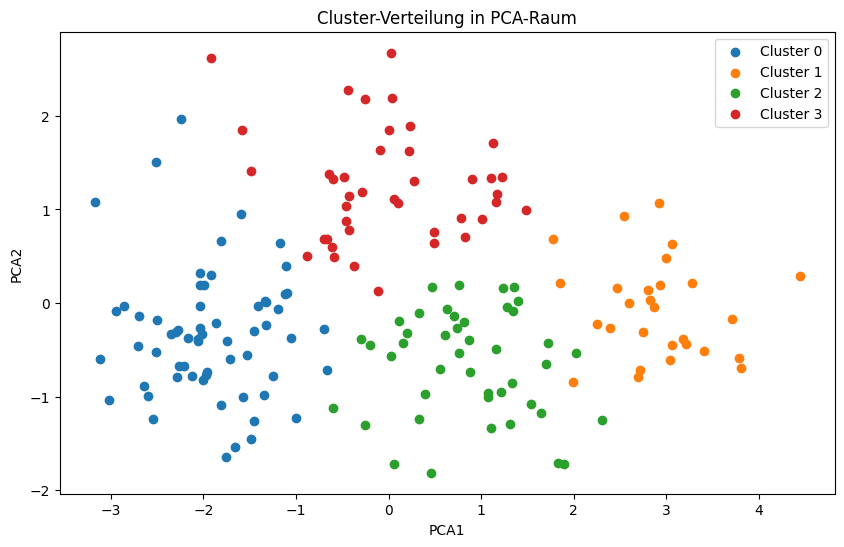

In [17]:
# Hauptkomponentenanalyse (PCA) mit zwei Komponenten zur Visualisierung
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled[feature_cols])
df_scaled["PCA1"], df_scaled["PCA2"] = components[:,0], components[:,1]

# Scatter-Plot zur Darstellung der Cluster im zweidimensionalen PCA-Raum
plt.figure(figsize=(10, 6))
for cluster in sorted(df_scaled["cluster"].unique()):
    subset = df_scaled[df_scaled["cluster"] == cluster]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=f"Cluster {cluster}")
plt.legend()
plt.title("Cluster-Verteilung in PCA-Raum")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.savefig(os.path.join(RESULTS_PATH, "pca_cluster.png"), dpi=300, bbox_inches="tight")
plt.show()

Die Visualisierung im PCA-Raum zeigt eine klare Trennung der vier Cluster. Auch wenn es ein paar Überschneidungen gibt, bestätigt die Projektion insgesamt die strukturelle Trennbarkeit der Gruppen im mehrdimensionalen Raum.

In [18]:
# Gesamter Silhouettenkoeffizient
sil_score = silhouette_score(df_scaled[CLUSTERING_VARIABLES], df_scaled["cluster"])
print(f"Silhouettenkoeffizient für k=4: {sil_score:.3f}")

Silhouettenkoeffizient für k=4: 0.386


Der durchschnittliche Silhouettenkoeffizient für die gewählte Clustering-Lösung mit vier Gruppen beträgt 0,387. Dieser Wert deutet auf eine ausreichende Trennschärfe zwischen den Clustern hin und unterstützt die Entscheidung für k=4.



In [19]:
print("Cluster Zentren:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=CLUSTERING_VARIABLES))

# Verteilung der Einkommensgruppen in den Clustern
print("Verteilung der Einkommensgruppen pro Cluster:")
print(pd.crosstab(df_scaled["cluster"], df_scaled["IncomeGroup"]), "\n")

# Verteilung der Weltregionen in den Clustern
print("Verteilung der Weltregionen pro Cluster:")
print(pd.crosstab(df_scaled["cluster"], df_scaled["Region"]))

Cluster Zentren:
   NY.GDP.PCAP.CD  SP.URB.TOTL.IN.ZS  IT.NET.USER.ZS  Avg Years Schooling  \
0       -0.623856          -1.022481       -1.116414            -1.045668   
1        1.996561           1.215355        1.339103             1.052237   
2       -0.131766           0.054369        0.539389             0.788587   
3       -0.278707           0.657845        0.194870             0.016365   

   SI.POV.GINI  
0     0.267171  
1    -0.838181  
2    -0.823080  
3     1.051706  
Verteilung der Einkommensgruppen pro Cluster:
IncomeGroup  High income  Low income  Lower middle income  Upper middle income
cluster                                                                       
0                      1          23                   31                    6
1                     28           0                    0                    0
2                     19           2                    5                   18
3                      6           1                   11              

Beschreibung der Cluster


Die vier ermittelten Cluster lassen sich inhaltlich gut voneinander abgrenzen:

- Cluster 0: Wirtschaftlich und infrastrukturell gemischte Länder mit höherer Ungleichheit. Hierzu zählen viele lateinamerikanische und MENA-Staaten sowie einige transformierende Volkswirtschaften.
- Cluster 1: Staaten mit niedrigem Entwicklungsstand, schwacher Infrastruktur und geringer Bildungsbeteiligung. Stark vertreten: Länder mit niedrigem Einkommen, vor allem in Subsahara-Afrika und Südasien.
- - Cluster 2: Hoch entwickelte Staaten mit sehr hohem BIP, hoher Bildung, starker Digitalisierung und vergleichsweise geringer Ungleichheit. Dominieren: High-Income-Staaten, vor allem in Europa und Nordamerika.
- Cluster 3: Bildungsstarke Länder mit mittlerem Einkommen, solider Infrastruktur und ebenfalls relativ geringer Ungleichheit. Auffällig viele Staaten aus Europa und Zentralasien.


Diese Differenzierung bildet eine solide Grundlage für die anschließende Analyse partizipativer Demokratie im Kontext struktureller Bedingungen.

## 3.4 Feature-Importance-Analyse innerhalb der Cluster

Zunächst wird ein Random-Forest-Modell auf dem Gesamtdatensatz trainiert, um die wichtigsten Einflussfaktoren auf die partizipative Demokratie zu identifizieren. Anschließend erfolgt dieselbe Analyse für jedes Cluster separat, um Unterschiede im Einfluss struktureller Merkmale zwischen Ländergruppen sichtbar zu machen.


 Globale Feature Importance – Gesamtdatensatz


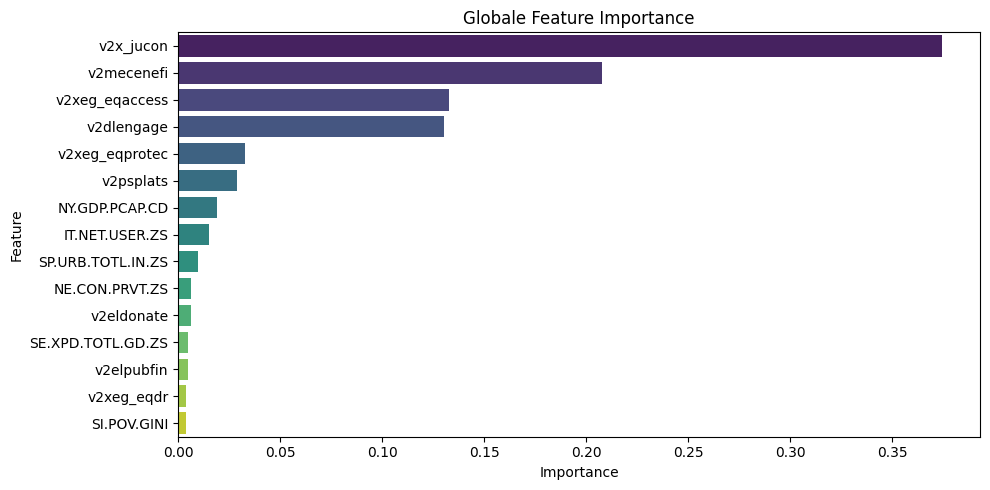


 Cluster 0.0 – Länderanzahl: 61


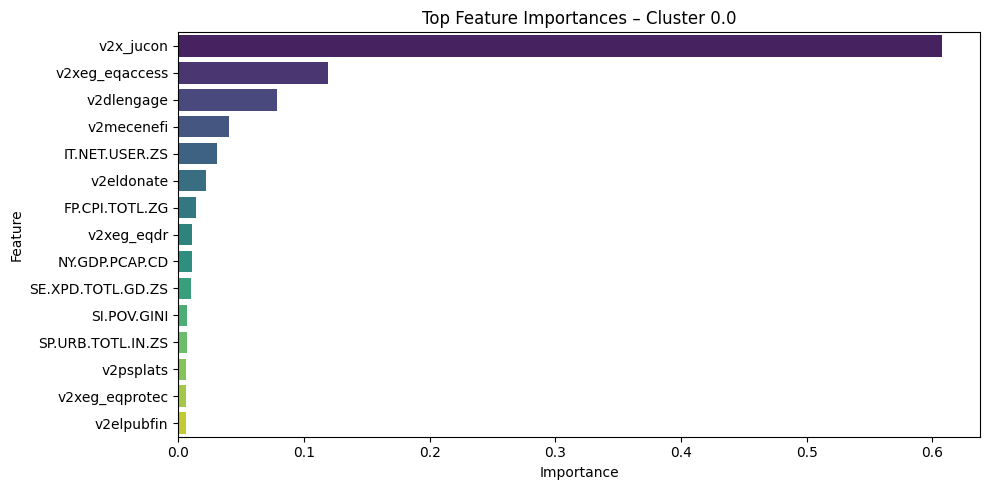


 Cluster 1.0 – Länderanzahl: 28


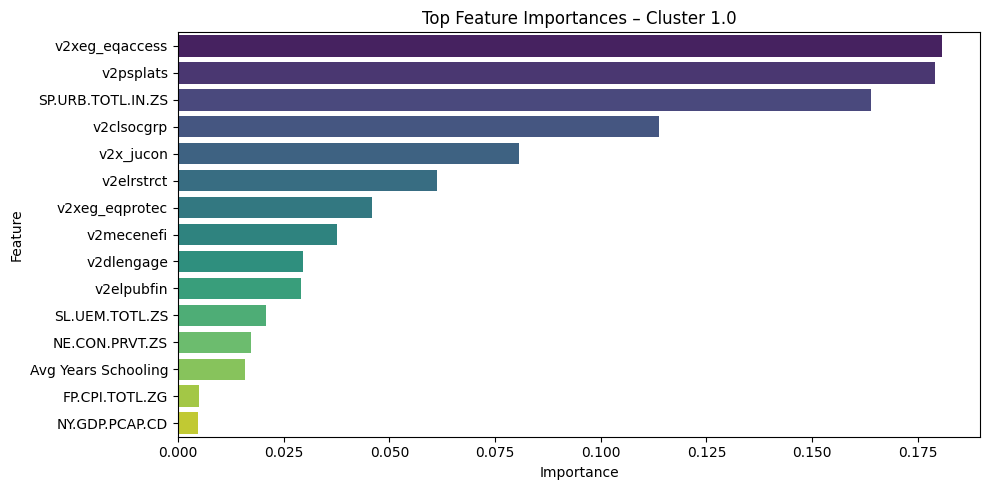


 Cluster 2.0 – Länderanzahl: 44


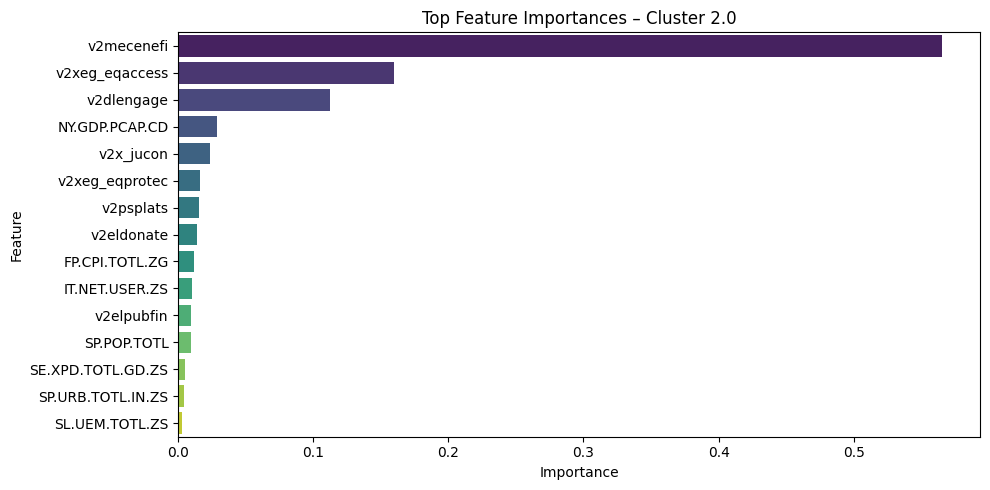


 Cluster 3.0 – Länderanzahl: 41


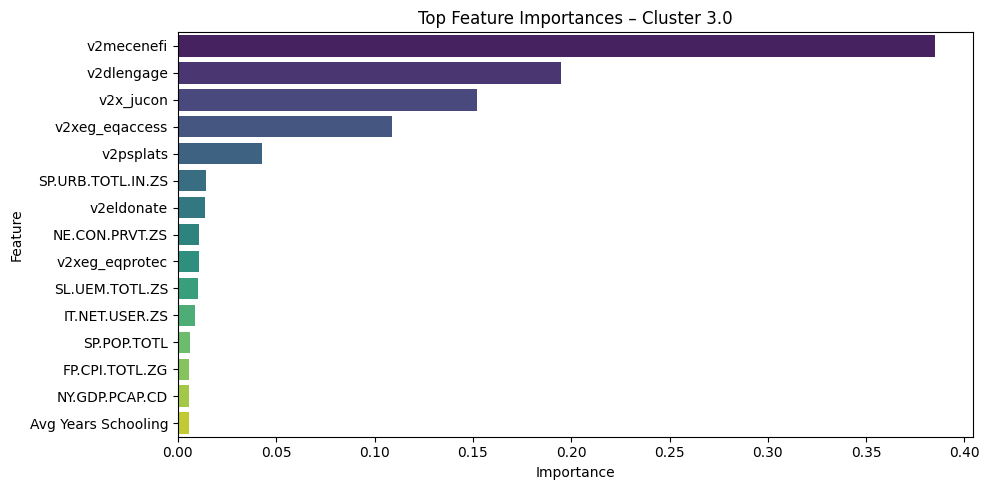

In [20]:
df_final = df_cleaned.merge(df_scaled[["Country Code", "cluster"]], on="Country Code", how="left")

# Zielvariable & Kontext
cluster_col = "cluster"

# Features: alle numerischen Spalten außer der Zielvariable
exclude_cols = ["Country Code", "Country Name", "Region", "IncomeGroup", TARGET_VARIABLE, cluster_col]
feature_cols = [col for col in df_final.select_dtypes(include=["float64", "int64"]).columns if col not in exclude_cols]

# Globale Feature Importance (über alle Länder hinweg)
print("\n Globale Feature Importance – Gesamtdatensatz")
X_all = df_final[feature_cols]
y_all = df_final[TARGET_VARIABLE]

rf_global = RandomForestRegressor(n_estimators=100, random_state=42)
rf_global.fit(X_all, y_all)

global_importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_global.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=global_importances.head(15),
    x="Importance",
    y="Feature",
    hue="Feature",
    palette="viridis",
    legend=False
)
plt.title("Globale Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, "globale_feature_importance.png"), dpi=300, bbox_inches="tight")
plt.show()


# Feature Importance für jeden Cluster
for cluster in sorted(df_final[cluster_col].dropna().unique()):
    print(f"\n Cluster {cluster} – Länderanzahl: {df_final[df_final[cluster_col] == cluster].shape[0]}")

    # Daten aus Cluster extrahieren
    df_cluster = df_final[df_final[cluster_col] == cluster]

    # X und y
    X = df_cluster[feature_cols]
    y = df_cluster[TARGET_VARIABLE]

    # Modell trainieren
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Feature Importance extrahieren
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(
    data=fi_df.head(15),
    x="Importance",
    y="Feature",
    hue="Feature",
    palette="viridis",
    legend=False
)
    plt.title(f"Top Feature Importances – Cluster {cluster}")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"feature_importance_{cluster}.png"), dpi=300, bbox_inches="tight")
    plt.show()


Die Visualisierungen der Feature-Importance-Analyse zeigen, dass sich die wichtigsten Einflussgrößen auf partizipative Demokratie je nach Cluster deutlich unterscheiden.

Im Gesamtdatensatz dominieren institutionelle Faktoren wie Justizunabhängigkeit (`v2x_jucon`) und Medienfreiheit (`v2mecenefi`) die Erklärung partizipativer Demokratie. Auch gleichheitsbezogene Variablen wie `v2xeg_eqaccess` und `v2dlengage` sind zentral.

In Cluster 0 (ungleiche, mittel entwickelte Länder) ist Medienfreiheit der stärkste Einflussfaktor, gefolgt von politischem Zugang und Justizunabhängigkeit. 

Cluster 1 (niedrig entwickelte Länder) zeigt ein ähnliches Muster: Institutionelle Merkmale wie Justiz, Teilhabe und Gleichheit sind entscheidend, sozioökonomische Faktoren spielen kaum eine Rolle.

In Cluster 2 (hoch entwickelte Länder) gewinnen gleichheits- und vielfaltsbezogene Variablen an Bedeutung, während klassische Entwicklungsindikatoren moderat wichtig bleiben.

Cluster 3 (bildungsstarke Mittelgruppe) wird ebenfalls stark durch Medienfreiheit, Gleichheit und zivilgesellschaftliche Beteiligung geprägt, während ökonomische Variablen geringere Relevanz aufweisen.

Die Unterschiede in den Rangfolgen und den dominanten Einflussgrößen legen nahe, dass partizipative Demokratie in verschiedenen Kontexten durch unterschiedliche Faktoren gefördert oder gehemmt wird.